In this example, we're using a simple Artificial Neural Network to predict the images from the labels.
For example, if we input the label 5 into the neural network, it should output an image with the digit 5 on it.

In [1]:
# torch comes from PyTorch, the most widely used deep learning library
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# torchvision is a library that contains many datasets and helper functions for image processing
import torchvision

# other imports that we need
import struct
import random
import numpy as np
from array import array
from os.path  import join
import matplotlib.pyplot as plt

# magic to show plots in the jupyter notebook
%matplotlib inline

# helper function to plot the data, which are images
def show_images(images, titles):
    cols = 5
    rows = len(images)//cols + 1
    plt.figure(figsize=(20,12))
    index = 0    
    for (image, title) in zip(images, titles):
        plt.subplot(rows, cols, index+1)        
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(title, fontsize = 8);        
        index += 1
    plt.show()
    plt.close()

# we don't need a GPU for this example, but as soon as we're dealing with bigger networks and larger data, we don't come around using a GPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# how many images are trained at once
batch_size = 32

# we're using MNIST, a dataset of handwritten digits. PyTorch has a helper function to download and prepare this dataset
train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

# we're using a data loader to load the images in batches of 32 during the training
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

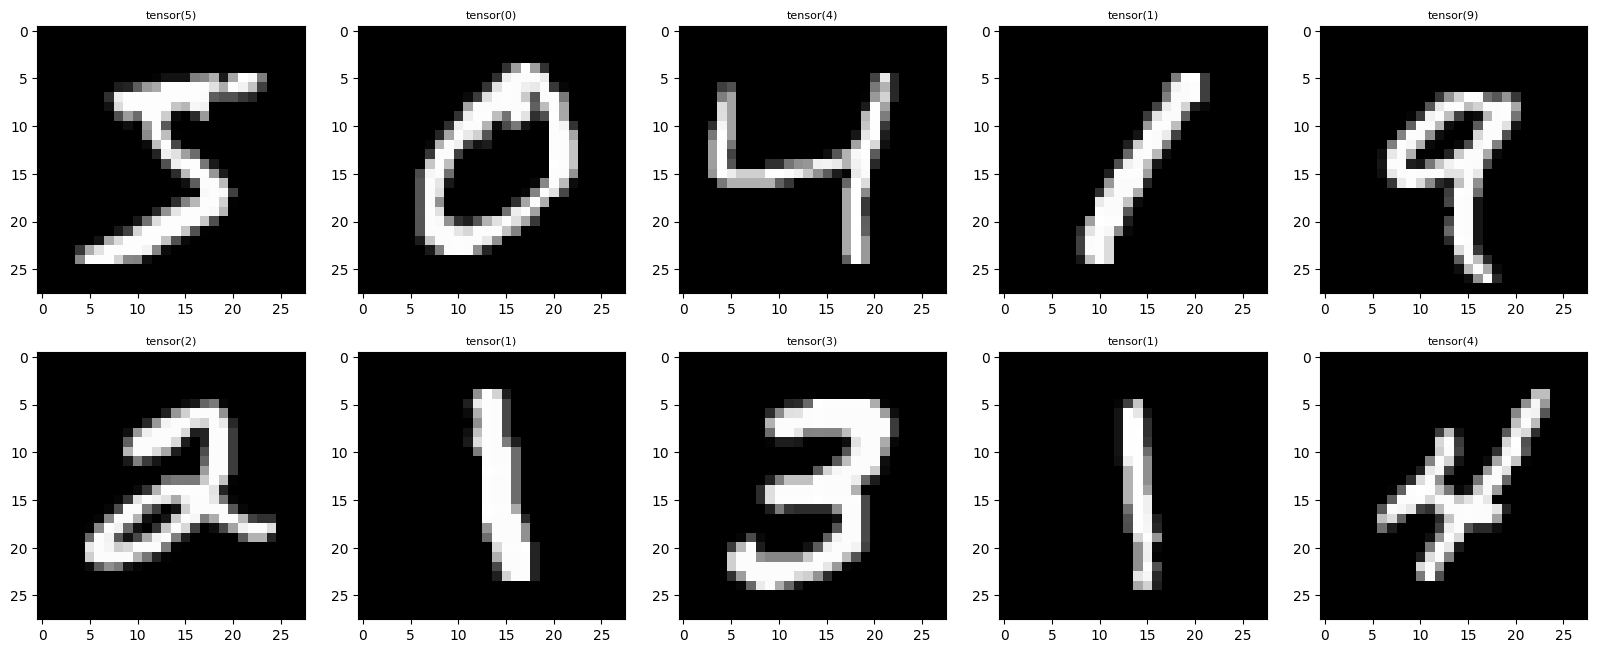

In [2]:
imgs_train = [train_dataset.data[i] for i in range(10)]
labels_train = train_dataset.targets[:10]

show_images(imgs_train, labels_train)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Linear(784, 784)

    def forward(self, x, label):
        label = torch.reshape(label, shape=(batch_size, 1))
        label = label.expand(batch_size, 784)
        x = torch.relu(torch.add(x, label))
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc0(x))
        x = torch.sigmoid(self.fc0(x))
        return x

net = Net()
net.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

[1,   100] loss: 0.084
[1,   200] loss: 0.071
[1,   300] loss: 0.070
[1,   400] loss: 0.070
[1,   500] loss: 0.069
[1,   600] loss: 0.067
[1,   700] loss: 0.066
[1,   800] loss: 0.064
[1,   900] loss: 0.063
[1,  1000] loss: 0.062
[1,  1100] loss: 0.063
[1,  1200] loss: 0.062
[1,  1300] loss: 0.062
[1,  1400] loss: 0.062
[1,  1500] loss: 0.061
[1,  1600] loss: 0.061
[1,  1700] loss: 0.062
[1,  1800] loss: 0.060


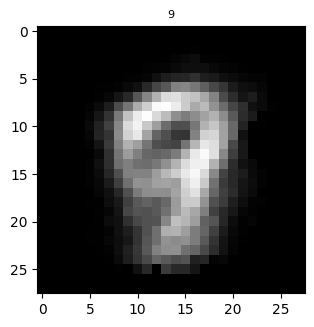

[2,   100] loss: 0.061
[2,   200] loss: 0.060
[2,   300] loss: 0.061
[2,   400] loss: 0.060
[2,   500] loss: 0.060
[2,   600] loss: 0.060
[2,   700] loss: 0.061
[2,   800] loss: 0.061
[2,   900] loss: 0.060
[2,  1000] loss: 0.060
[2,  1100] loss: 0.060
[2,  1200] loss: 0.060
[2,  1300] loss: 0.059
[2,  1400] loss: 0.060
[2,  1500] loss: 0.060
[2,  1600] loss: 0.060
[2,  1700] loss: 0.059
[2,  1800] loss: 0.059


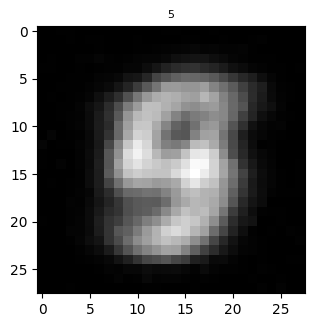

[3,   100] loss: 0.060
[3,   200] loss: 0.058
[3,   300] loss: 0.060
[3,   400] loss: 0.059
[3,   500] loss: 0.059
[3,   600] loss: 0.058
[3,   700] loss: 0.059
[3,   800] loss: 0.059
[3,   900] loss: 0.058
[3,  1000] loss: 0.058
[3,  1100] loss: 0.058
[3,  1200] loss: 0.058
[3,  1300] loss: 0.058
[3,  1400] loss: 0.058
[3,  1500] loss: 0.058
[3,  1600] loss: 0.057
[3,  1700] loss: 0.058
[3,  1800] loss: 0.058


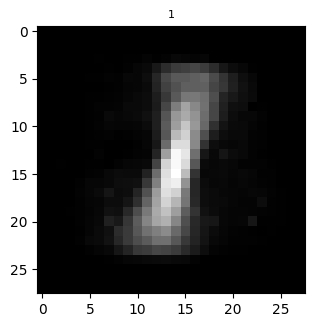

[4,   100] loss: 0.057
[4,   200] loss: 0.058
[4,   300] loss: 0.058
[4,   400] loss: 0.058
[4,   500] loss: 0.058
[4,   600] loss: 0.057
[4,   700] loss: 0.058
[4,   800] loss: 0.057
[4,   900] loss: 0.057
[4,  1000] loss: 0.057
[4,  1100] loss: 0.057
[4,  1200] loss: 0.057
[4,  1300] loss: 0.058
[4,  1400] loss: 0.057
[4,  1500] loss: 0.057
[4,  1600] loss: 0.057
[4,  1700] loss: 0.057
[4,  1800] loss: 0.057


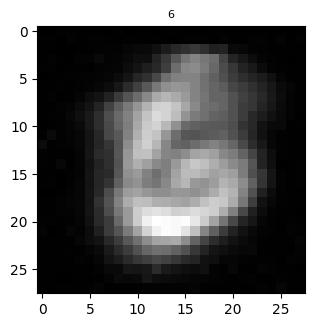

[5,   100] loss: 0.057
[5,   200] loss: 0.057
[5,   300] loss: 0.057
[5,   400] loss: 0.057
[5,   500] loss: 0.057
[5,   600] loss: 0.057
[5,   700] loss: 0.057
[5,   800] loss: 0.057
[5,   900] loss: 0.057
[5,  1000] loss: 0.057
[5,  1100] loss: 0.056
[5,  1200] loss: 0.056
[5,  1300] loss: 0.057
[5,  1400] loss: 0.057
[5,  1500] loss: 0.057
[5,  1600] loss: 0.056
[5,  1700] loss: 0.056
[5,  1800] loss: 0.057


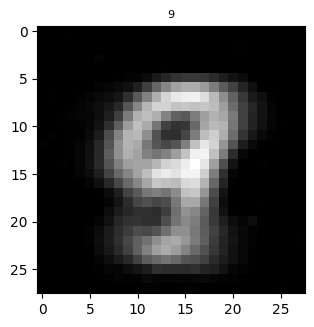

[6,   100] loss: 0.056
[6,   200] loss: 0.057
[6,   300] loss: 0.057
[6,   400] loss: 0.056
[6,   500] loss: 0.057
[6,   600] loss: 0.057
[6,   700] loss: 0.056
[6,   800] loss: 0.056
[6,   900] loss: 0.056
[6,  1000] loss: 0.056
[6,  1100] loss: 0.055
[6,  1200] loss: 0.056
[6,  1300] loss: 0.055
[6,  1400] loss: 0.057
[6,  1500] loss: 0.056
[6,  1600] loss: 0.055
[6,  1700] loss: 0.056
[6,  1800] loss: 0.056


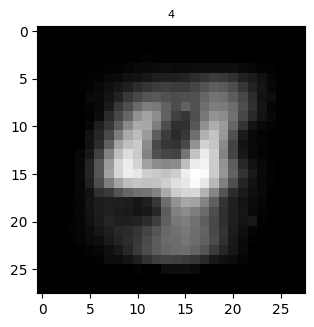

[7,   100] loss: 0.056
[7,   200] loss: 0.055
[7,   300] loss: 0.056
[7,   400] loss: 0.056
[7,   500] loss: 0.055
[7,   600] loss: 0.055
[7,   700] loss: 0.055
[7,   800] loss: 0.056
[7,   900] loss: 0.055
[7,  1000] loss: 0.055
[7,  1100] loss: 0.055
[7,  1200] loss: 0.055
[7,  1300] loss: 0.056
[7,  1400] loss: 0.055
[7,  1500] loss: 0.055
[7,  1600] loss: 0.055
[7,  1700] loss: 0.055
[7,  1800] loss: 0.056


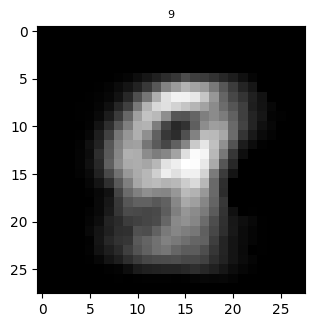

[8,   100] loss: 0.055
[8,   200] loss: 0.055
[8,   300] loss: 0.055
[8,   400] loss: 0.055
[8,   500] loss: 0.054
[8,   600] loss: 0.054
[8,   700] loss: 0.054
[8,   800] loss: 0.055
[8,   900] loss: 0.054
[8,  1000] loss: 0.054
[8,  1100] loss: 0.054
[8,  1200] loss: 0.055
[8,  1300] loss: 0.054
[8,  1400] loss: 0.054
[8,  1500] loss: 0.054
[8,  1600] loss: 0.055
[8,  1700] loss: 0.055
[8,  1800] loss: 0.054


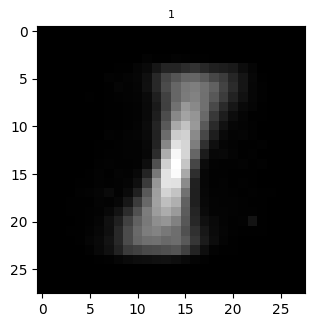

[9,   100] loss: 0.055
[9,   200] loss: 0.054
[9,   300] loss: 0.054
[9,   400] loss: 0.054
[9,   500] loss: 0.054
[9,   600] loss: 0.054
[9,   700] loss: 0.054
[9,   800] loss: 0.054
[9,   900] loss: 0.055
[9,  1000] loss: 0.055
[9,  1100] loss: 0.054
[9,  1200] loss: 0.054
[9,  1300] loss: 0.054
[9,  1400] loss: 0.054
[9,  1500] loss: 0.054
[9,  1600] loss: 0.054
[9,  1700] loss: 0.054
[9,  1800] loss: 0.054


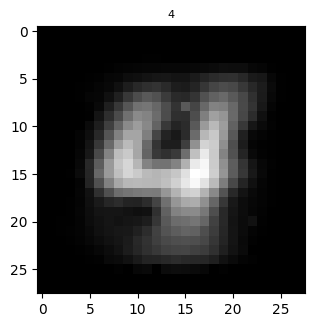

[10,   100] loss: 0.054
[10,   200] loss: 0.054
[10,   300] loss: 0.054
[10,   400] loss: 0.054
[10,   500] loss: 0.054
[10,   600] loss: 0.054
[10,   700] loss: 0.054
[10,   800] loss: 0.054
[10,   900] loss: 0.054
[10,  1000] loss: 0.054
[10,  1100] loss: 0.054
[10,  1200] loss: 0.054
[10,  1300] loss: 0.054
[10,  1400] loss: 0.054
[10,  1500] loss: 0.054
[10,  1600] loss: 0.054
[10,  1700] loss: 0.054
[10,  1800] loss: 0.053


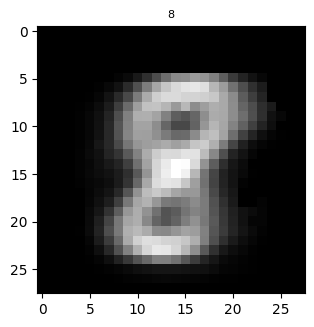

[11,   100] loss: 0.055
[11,   200] loss: 0.054
[11,   300] loss: 0.054
[11,   400] loss: 0.054
[11,   500] loss: 0.053
[11,   600] loss: 0.054
[11,   700] loss: 0.054
[11,   800] loss: 0.054
[11,   900] loss: 0.054
[11,  1000] loss: 0.054
[11,  1100] loss: 0.053
[11,  1200] loss: 0.054
[11,  1300] loss: 0.054
[11,  1400] loss: 0.054
[11,  1500] loss: 0.054
[11,  1600] loss: 0.053
[11,  1700] loss: 0.054
[11,  1800] loss: 0.054


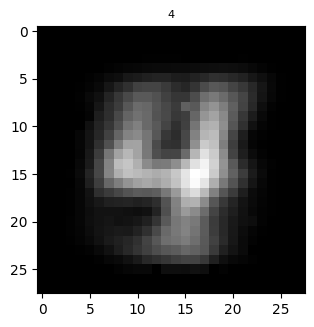

[12,   100] loss: 0.054
[12,   200] loss: 0.054
[12,   300] loss: 0.053
[12,   400] loss: 0.054
[12,   500] loss: 0.053
[12,   600] loss: 0.054
[12,   700] loss: 0.053
[12,   800] loss: 0.053
[12,   900] loss: 0.054
[12,  1000] loss: 0.054
[12,  1100] loss: 0.054
[12,  1200] loss: 0.054
[12,  1300] loss: 0.054
[12,  1400] loss: 0.054
[12,  1500] loss: 0.054
[12,  1600] loss: 0.053
[12,  1700] loss: 0.053
[12,  1800] loss: 0.054


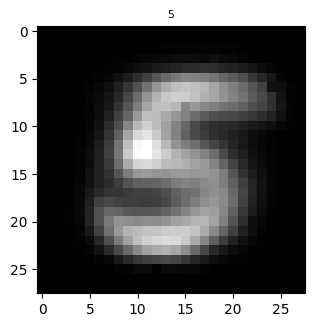

[13,   100] loss: 0.053
[13,   200] loss: 0.054
[13,   300] loss: 0.054
[13,   400] loss: 0.054
[13,   500] loss: 0.053
[13,   600] loss: 0.054
[13,   700] loss: 0.054
[13,   800] loss: 0.054
[13,   900] loss: 0.053
[13,  1000] loss: 0.054
[13,  1100] loss: 0.054
[13,  1200] loss: 0.054
[13,  1300] loss: 0.054
[13,  1400] loss: 0.054
[13,  1500] loss: 0.053
[13,  1600] loss: 0.054
[13,  1700] loss: 0.054
[13,  1800] loss: 0.054


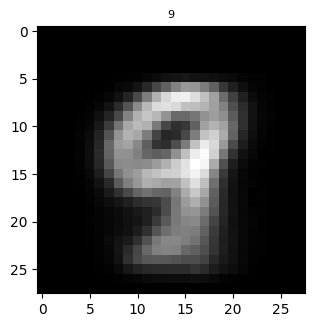

[14,   100] loss: 0.054
[14,   200] loss: 0.054
[14,   300] loss: 0.053
[14,   400] loss: 0.054
[14,   500] loss: 0.054
[14,   600] loss: 0.054
[14,   700] loss: 0.054
[14,   800] loss: 0.054
[14,   900] loss: 0.054
[14,  1000] loss: 0.054
[14,  1100] loss: 0.054
[14,  1200] loss: 0.054
[14,  1300] loss: 0.054
[14,  1400] loss: 0.054
[14,  1500] loss: 0.054
[14,  1600] loss: 0.053
[14,  1700] loss: 0.054
[14,  1800] loss: 0.054


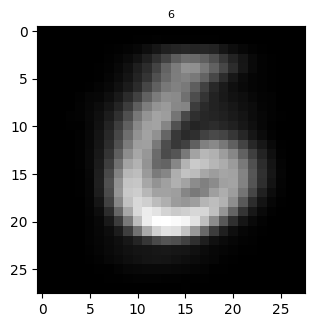

[15,   100] loss: 0.053
[15,   200] loss: 0.054
[15,   300] loss: 0.054
[15,   400] loss: 0.054
[15,   500] loss: 0.054
[15,   600] loss: 0.054
[15,   700] loss: 0.054
[15,   800] loss: 0.053
[15,   900] loss: 0.054
[15,  1000] loss: 0.054
[15,  1100] loss: 0.054
[15,  1200] loss: 0.054
[15,  1300] loss: 0.054
[15,  1400] loss: 0.054
[15,  1500] loss: 0.054
[15,  1600] loss: 0.054
[15,  1700] loss: 0.054
[15,  1800] loss: 0.054


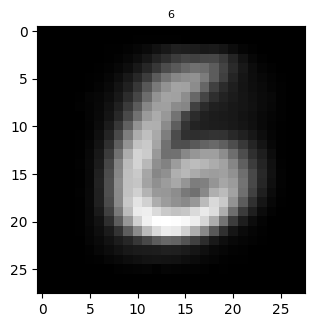

[16,   100] loss: 0.054
[16,   200] loss: 0.054
[16,   300] loss: 0.054
[16,   400] loss: 0.054
[16,   500] loss: 0.054
[16,   600] loss: 0.054
[16,   700] loss: 0.054
[16,   800] loss: 0.054
[16,   900] loss: 0.053
[16,  1000] loss: 0.054
[16,  1100] loss: 0.054
[16,  1200] loss: 0.054
[16,  1300] loss: 0.053
[16,  1400] loss: 0.053
[16,  1500] loss: 0.053
[16,  1600] loss: 0.054
[16,  1700] loss: 0.054
[16,  1800] loss: 0.054


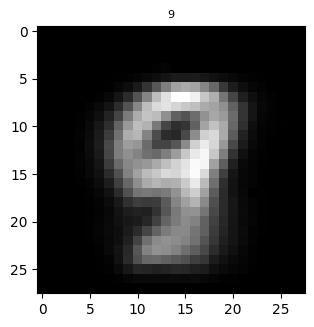

[17,   100] loss: 0.054
[17,   200] loss: 0.053
[17,   300] loss: 0.054
[17,   400] loss: 0.054
[17,   500] loss: 0.054
[17,   600] loss: 0.054
[17,   700] loss: 0.053
[17,   800] loss: 0.053
[17,   900] loss: 0.053
[17,  1000] loss: 0.054
[17,  1100] loss: 0.054
[17,  1200] loss: 0.054
[17,  1300] loss: 0.054
[17,  1400] loss: 0.053
[17,  1500] loss: 0.054
[17,  1600] loss: 0.054
[17,  1700] loss: 0.054
[17,  1800] loss: 0.054


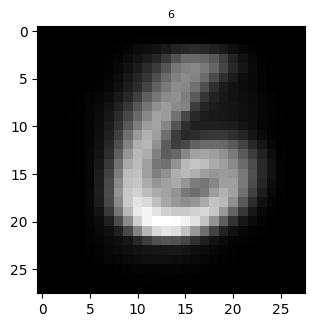

[18,   100] loss: 0.054
[18,   200] loss: 0.054
[18,   300] loss: 0.053
[18,   400] loss: 0.054
[18,   500] loss: 0.054
[18,   600] loss: 0.054
[18,   700] loss: 0.053
[18,   800] loss: 0.054
[18,   900] loss: 0.054
[18,  1000] loss: 0.054
[18,  1100] loss: 0.054
[18,  1200] loss: 0.054
[18,  1300] loss: 0.054
[18,  1400] loss: 0.054
[18,  1500] loss: 0.053
[18,  1600] loss: 0.054
[18,  1700] loss: 0.053
[18,  1800] loss: 0.054


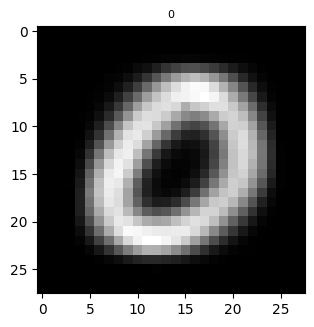

[19,   100] loss: 0.054
[19,   200] loss: 0.053
[19,   300] loss: 0.054
[19,   400] loss: 0.054
[19,   500] loss: 0.054
[19,   600] loss: 0.053
[19,   700] loss: 0.054
[19,   800] loss: 0.053
[19,   900] loss: 0.054
[19,  1000] loss: 0.054
[19,  1100] loss: 0.054
[19,  1200] loss: 0.054
[19,  1300] loss: 0.054
[19,  1400] loss: 0.054
[19,  1500] loss: 0.054
[19,  1600] loss: 0.054
[19,  1700] loss: 0.054
[19,  1800] loss: 0.053


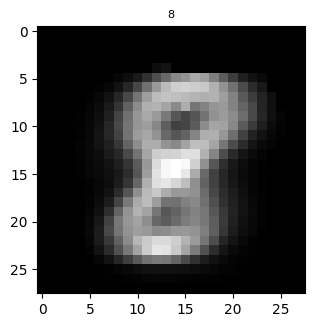

[20,   100] loss: 0.054
[20,   200] loss: 0.053
[20,   300] loss: 0.054
[20,   400] loss: 0.054
[20,   500] loss: 0.054
[20,   600] loss: 0.054
[20,   700] loss: 0.054
[20,   800] loss: 0.054
[20,   900] loss: 0.054
[20,  1000] loss: 0.054
[20,  1100] loss: 0.054
[20,  1200] loss: 0.053
[20,  1300] loss: 0.054
[20,  1400] loss: 0.053
[20,  1500] loss: 0.054
[20,  1600] loss: 0.054
[20,  1700] loss: 0.054
[20,  1800] loss: 0.054


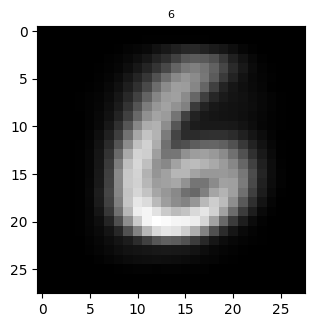

[21,   100] loss: 0.054
[21,   200] loss: 0.053
[21,   300] loss: 0.054
[21,   400] loss: 0.054
[21,   500] loss: 0.054
[21,   600] loss: 0.053
[21,   700] loss: 0.053
[21,   800] loss: 0.054
[21,   900] loss: 0.054
[21,  1000] loss: 0.054
[21,  1100] loss: 0.054
[21,  1200] loss: 0.053
[21,  1300] loss: 0.054
[21,  1400] loss: 0.054
[21,  1500] loss: 0.054
[21,  1600] loss: 0.054
[21,  1700] loss: 0.053
[21,  1800] loss: 0.054


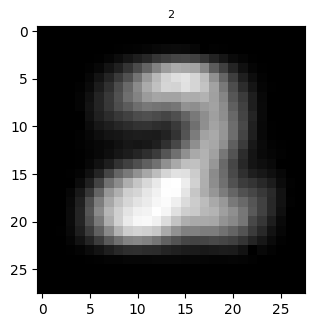

[22,   100] loss: 0.054
[22,   200] loss: 0.053
[22,   300] loss: 0.054
[22,   400] loss: 0.053
[22,   500] loss: 0.053
[22,   600] loss: 0.054
[22,   700] loss: 0.054
[22,   800] loss: 0.054
[22,   900] loss: 0.054
[22,  1000] loss: 0.054
[22,  1100] loss: 0.054
[22,  1200] loss: 0.053
[22,  1300] loss: 0.054
[22,  1400] loss: 0.054
[22,  1500] loss: 0.054
[22,  1600] loss: 0.054
[22,  1700] loss: 0.054
[22,  1800] loss: 0.053


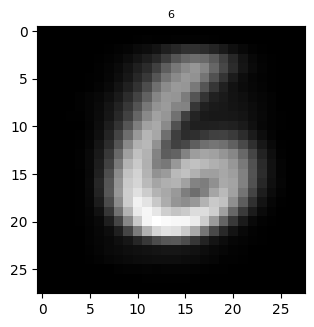

[23,   100] loss: 0.054
[23,   200] loss: 0.054
[23,   300] loss: 0.054
[23,   400] loss: 0.053
[23,   500] loss: 0.054
[23,   600] loss: 0.053
[23,   700] loss: 0.054
[23,   800] loss: 0.053
[23,   900] loss: 0.054
[23,  1000] loss: 0.054
[23,  1100] loss: 0.054
[23,  1200] loss: 0.053
[23,  1300] loss: 0.054
[23,  1400] loss: 0.054
[23,  1500] loss: 0.054
[23,  1600] loss: 0.053
[23,  1700] loss: 0.054
[23,  1800] loss: 0.054


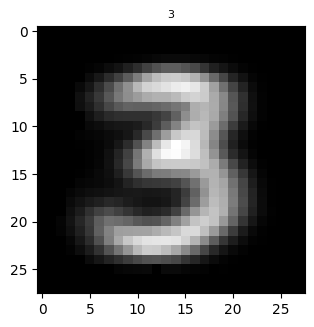

[24,   100] loss: 0.054
[24,   200] loss: 0.053
[24,   300] loss: 0.054
[24,   400] loss: 0.054
[24,   500] loss: 0.054
[24,   600] loss: 0.053
[24,   700] loss: 0.053
[24,   800] loss: 0.053
[24,   900] loss: 0.053
[24,  1000] loss: 0.053
[24,  1100] loss: 0.054
[24,  1200] loss: 0.054
[24,  1300] loss: 0.054
[24,  1400] loss: 0.053
[24,  1500] loss: 0.054
[24,  1600] loss: 0.054
[24,  1700] loss: 0.054
[24,  1800] loss: 0.054


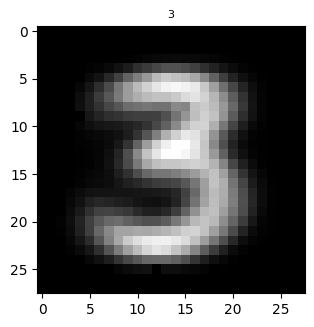

[25,   100] loss: 0.054
[25,   200] loss: 0.054
[25,   300] loss: 0.053
[25,   400] loss: 0.054
[25,   500] loss: 0.053
[25,   600] loss: 0.054
[25,   700] loss: 0.053
[25,   800] loss: 0.054
[25,   900] loss: 0.054
[25,  1000] loss: 0.054
[25,  1100] loss: 0.054
[25,  1200] loss: 0.054
[25,  1300] loss: 0.053
[25,  1400] loss: 0.054
[25,  1500] loss: 0.053
[25,  1600] loss: 0.054
[25,  1700] loss: 0.054
[25,  1800] loss: 0.054


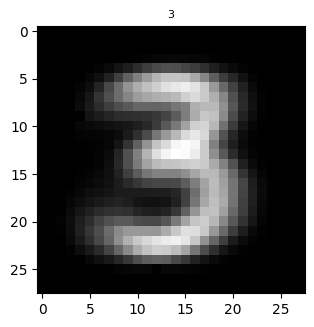

[26,   100] loss: 0.054
[26,   200] loss: 0.054
[26,   300] loss: 0.053
[26,   400] loss: 0.053
[26,   500] loss: 0.054
[26,   600] loss: 0.054
[26,   700] loss: 0.054
[26,   800] loss: 0.053
[26,   900] loss: 0.053
[26,  1000] loss: 0.053
[26,  1100] loss: 0.054
[26,  1200] loss: 0.053
[26,  1300] loss: 0.053
[26,  1400] loss: 0.053
[26,  1500] loss: 0.053
[26,  1600] loss: 0.054
[26,  1700] loss: 0.054
[26,  1800] loss: 0.054


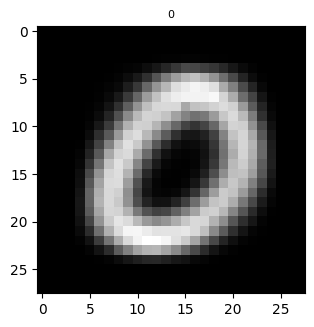

[27,   100] loss: 0.054
[27,   200] loss: 0.053
[27,   300] loss: 0.054
[27,   400] loss: 0.054
[27,   500] loss: 0.054
[27,   600] loss: 0.054
[27,   700] loss: 0.054
[27,   800] loss: 0.054
[27,   900] loss: 0.054
[27,  1000] loss: 0.054
[27,  1100] loss: 0.054
[27,  1200] loss: 0.054
[27,  1300] loss: 0.054
[27,  1400] loss: 0.053
[27,  1500] loss: 0.053
[27,  1600] loss: 0.054
[27,  1700] loss: 0.054
[27,  1800] loss: 0.054


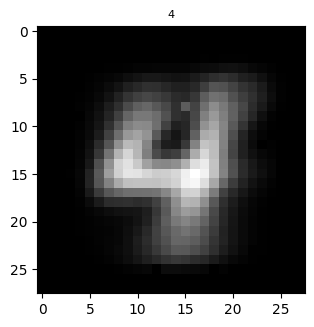

[28,   100] loss: 0.053
[28,   200] loss: 0.054
[28,   300] loss: 0.053
[28,   400] loss: 0.054
[28,   500] loss: 0.054
[28,   600] loss: 0.054
[28,   700] loss: 0.053
[28,   800] loss: 0.054
[28,   900] loss: 0.054
[28,  1000] loss: 0.054
[28,  1100] loss: 0.053
[28,  1200] loss: 0.053
[28,  1300] loss: 0.054
[28,  1400] loss: 0.054
[28,  1500] loss: 0.053
[28,  1600] loss: 0.054
[28,  1700] loss: 0.053
[28,  1800] loss: 0.054


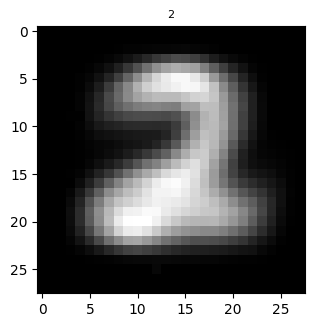

[29,   100] loss: 0.054
[29,   200] loss: 0.054
[29,   300] loss: 0.053
[29,   400] loss: 0.053
[29,   500] loss: 0.054
[29,   600] loss: 0.054
[29,   700] loss: 0.053
[29,   800] loss: 0.054
[29,   900] loss: 0.054
[29,  1000] loss: 0.054
[29,  1100] loss: 0.053
[29,  1200] loss: 0.054
[29,  1300] loss: 0.053
[29,  1400] loss: 0.054
[29,  1500] loss: 0.054
[29,  1600] loss: 0.054
[29,  1700] loss: 0.054
[29,  1800] loss: 0.054


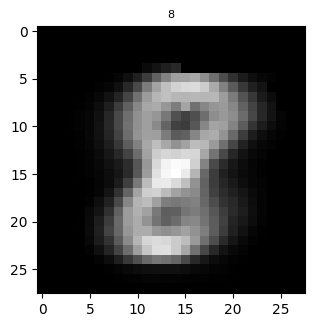

[30,   100] loss: 0.054
[30,   200] loss: 0.053
[30,   300] loss: 0.054
[30,   400] loss: 0.053
[30,   500] loss: 0.054
[30,   600] loss: 0.053
[30,   700] loss: 0.054
[30,   800] loss: 0.054
[30,   900] loss: 0.054
[30,  1000] loss: 0.054
[30,  1100] loss: 0.054
[30,  1200] loss: 0.054
[30,  1300] loss: 0.054
[30,  1400] loss: 0.054
[30,  1500] loss: 0.053
[30,  1600] loss: 0.054
[30,  1700] loss: 0.054
[30,  1800] loss: 0.054


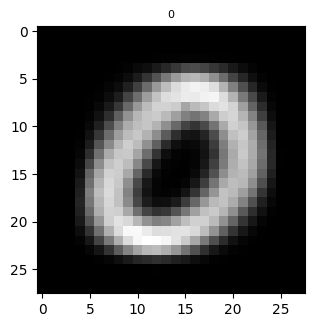

Finished Training


In [4]:
PATH = './models/handwritten_digit_creation_net.pth'

for epoch in range(30):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        x = torch.normal(0.0, 1.0, size=(batch_size, 784), device = device)

        optimizer.zero_grad()

        predicted = net(x, labels)

        loss = criterion(predicted, torch.reshape(inputs.float(), shape=(batch_size, 784)))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    show_images(torch.reshape(predicted[0], shape=(1,28,28)).cpu().detach().numpy(),  labels[0:1].cpu().detach().numpy())

    torch.save(net.state_dict(), PATH)

print('Finished Training')

Ground Truth


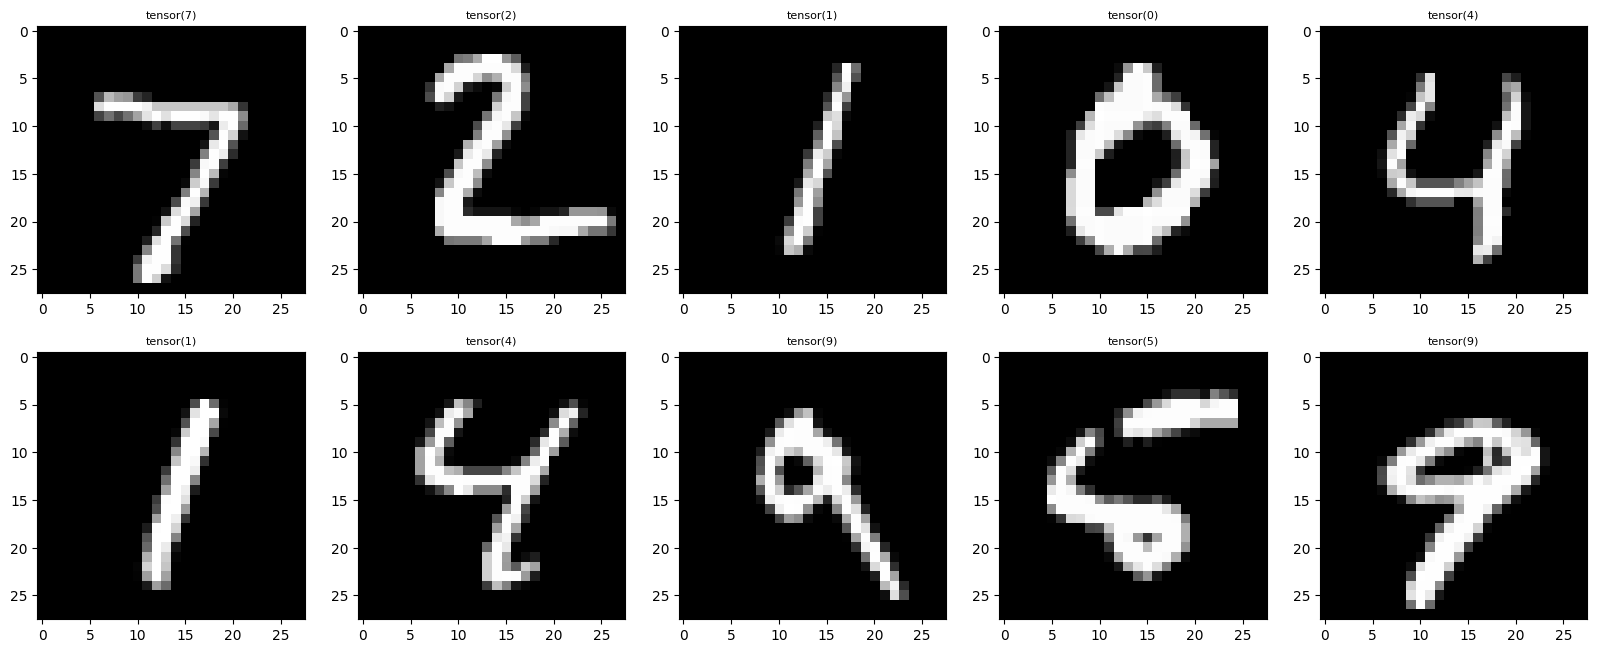


Created


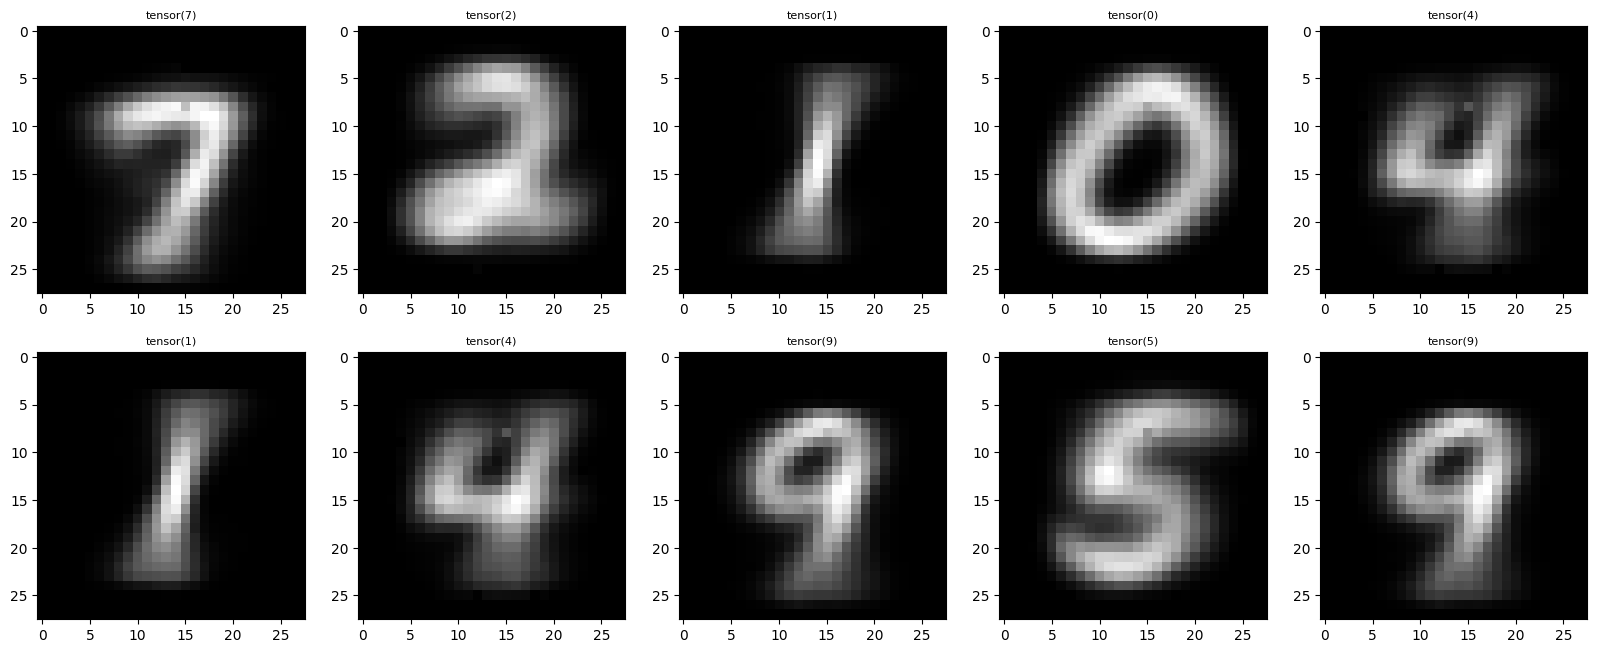

In [5]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()

dataiter = iter(testloader)
inputs, labels = dataiter.next()

inputs_qualitative = inputs.to(device)
labels_qualitative = labels.to(device)

x_qualitative = torch.normal(0.0, 1.0, size=(batch_size, 784), device = device)

predicted_qualitative = net(x_qualitative, labels_qualitative)

imgs_qualitative = [inputs_qualitative[i].squeeze(0).cpu() for i in range(10)]
labels_qualitative = [labels_qualitative[i] for i in range(10)]

predicted_qualitative = torch.reshape(predicted_qualitative, shape=(batch_size, 28, 28))
predicted_qualitative = [predicted_qualitative[i].squeeze(0).cpu().detach().numpy() for i in range(10)]

print("Ground Truth")
show_images(imgs_qualitative, labels_qualitative)
print()
print("Created")
show_images(predicted_qualitative, labels_qualitative)